# Mini Proyecto 1 (Andrés Lenis y Daniel Steven Moreno)

In [14]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import re
import pandas as pd
import random
import webcolors

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE




In [15]:
# Función para cargar imágenes desde un directorio dado
def load_images(root_path):
    files = os.listdir(root_path)
    random.shuffle(files)
    images_original = []
    for file in files:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images_original.append({'image': img, 'name': file})
    return images_original

In [16]:
# Función para preprocesar las imágenes (escalar, normalizar, cambiar tamaño)
def pre_process_image(images_original, flatten=False, normalize=False, target_size=None):
    images_process = []
    for data in images_original:
        height, width = data['image'].shape[:2]
        if target_size is not None:
            ratio = float(target_size) / max(height, width)
            new_height = int(height * ratio)
            new_width = int(width * ratio)
            image = cv2.resize(data['image'], (new_width,new_height))

        if flatten:
            image = image.reshape((-1, 3))
        if normalize:
            image = image / 255.0
        images_process.append(image)
    return images_process

In [17]:
# Función para aplicar el algoritmo de K-means a una imagen
def kmeans_image(img,num_clusters):
    kmeans = KMeans(n_clusters=num_clusters,random_state=42)
    kmeans.fit(img)
    return kmeans.cluster_centers_, kmeans.labels_

In [18]:
# Función para convertir un color RGB a su código hexadecimal
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

In [19]:
# Función para aplicar PCA o t-SNE a una imagen y visualizarla
def dimensionality_reduction(img, colors, tsne=False,p=3):
    if not tsne:
        pca = PCA(n_components=2)
        x_train_reduced = pca.fit_transform(img)
    else:
        tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=1)
        x_train_reduced = tsne.fit_transform(img)
    print('>>',x_train_reduced.shape)

    colors = colors * 255
    colors = list(map(rgb_to_hex,colors))
    # colors
    color_dict = {}
    for i in colors:
        color_dict[i] = i
    color_dict
    colors = np.array(colors)

    for category in np.unique(colors):
        mask = colors == category
        # print(mask)
        plt.scatter(x_train_reduced[:,0][mask], x_train_reduced[:,1][mask], label=category, color=color_dict[category],edgecolors='black')

    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label')
    plt.title('Scatter Plot with Categories')
    plt.legend()  # Show legend

    # Show plot
    plt.show()
    return x_train_reduced

In [20]:
def rgb_to_color_hex(rgb_tuple):
    try:
        color_name = webcolors.rgb_to_hex(rgb_tuple)
    except ValueError:
        color_name = 'Unknown'
    return color_name

In [21]:
# Función para visualizar la paleta de colores de una imagen junto con sus colores predominantes
def draw_image_palette(image_original, centroids=None):
    #for data in images_original:
    palette = centroids * 255
    title = image_original['name'][:-3]
    title = re.sub(r'[^A-Za-z0-9\-]+', ' ', title).upper()
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"{title}")
    plt.imshow(image_original['image'])
    plt.axis('off')
    
    if centroids is not None:
        plt.subplot(1, 2, 2)
        plt.title('Palette')
        palette_colors = []
        color_names = []
        for color in palette:
            palette_colors.append(color)
            color_name = rgb_to_color_hex(tuple(color.astype(int)))
            color_names.append(color_name)
        plt.imshow(np.expand_dims(palette_colors, axis=0).astype(np.uint8))
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        for i, name in enumerate(color_names):
            plt.text(i, .5, name, ha='center', va='top', color='black', fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
# Función para visualizar una serie de colores
def plot_colors(colors):
    plt.figure(figsize=(8, 6))
    for i in range(len(colors)):
        color_swatch = np.zeros((100, 100, 3))
        color_swatch[:, :, :] = colors[i]
        plt.subplot(1, len(colors), i + 1)
        plt.imshow(color_swatch)
        plt.axis('off')
    plt.show()

In [23]:
# Función para el método del codo
def elbow_method(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    # Plotting the elbow method graph
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

In [24]:
# Función para el análisis de silueta
def silhouette_analysis(data, max_clusters=10):
    silhouette_scores = []
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    # Plotting silhouette scores
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.show()

In [25]:
# Función para graficar el coeficiente de silueta para diferentes números de clusters
def silhouette_plot(data, max_clusters=10):
    scores = []
    for i in range(2, max_clusters + 1):
        model_k = KMeans(n_clusters=i, n_init=10, random_state=42)
        # Entrenamos el modelo
        model_k.fit(data)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(data, model_k.labels_)
        scores.append(score)
    # Mostramos los valores de los coeficientes
    display(pd.DataFrame({'K': range(2, max_clusters+1), 'Coeficiente': scores}))
    # Graficamos los valores del coeficiente de la silueta
    plt.plot(range(2, max_clusters+1), scores, marker='o')
    plt.xlabel('Número de clústeres')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

****************************************0************************************


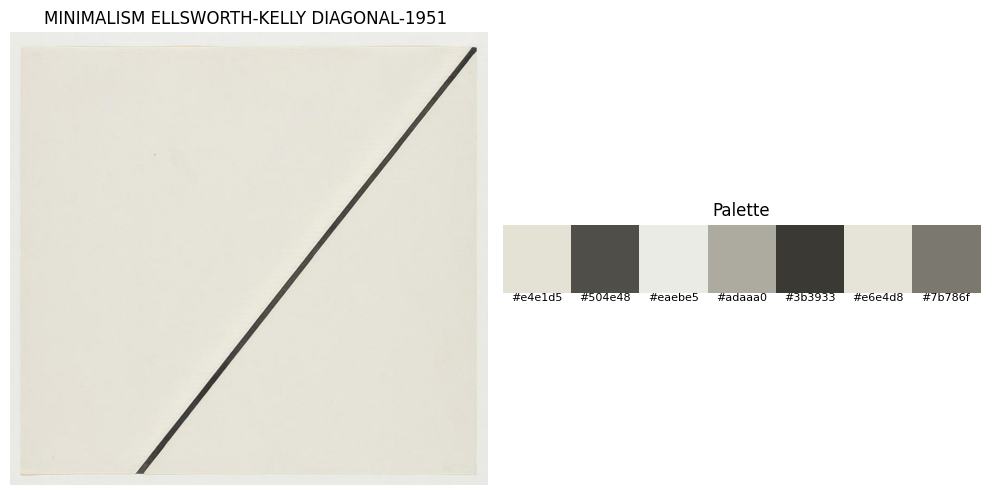

>> (9400, 2)


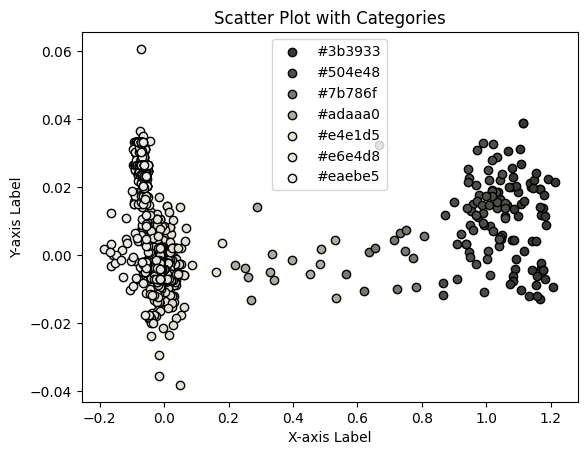

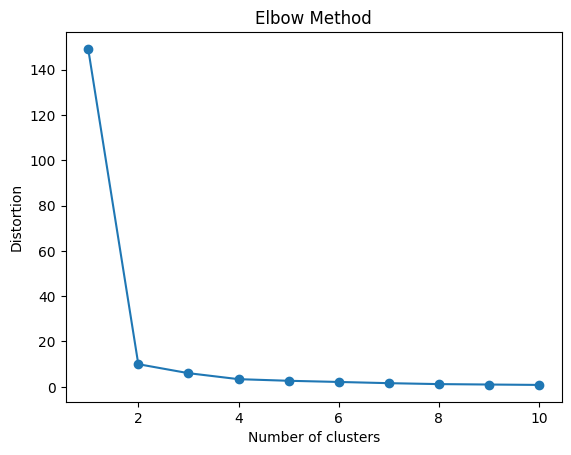

,K,Coeficiente
0,2,0.974185
1,3,0.782770
2,4,0.786050
3,5,0.784894
4,6,0.582848
5,7,0.579965
6,8,0.578600
7,9,0.578760
8,10,0.622316


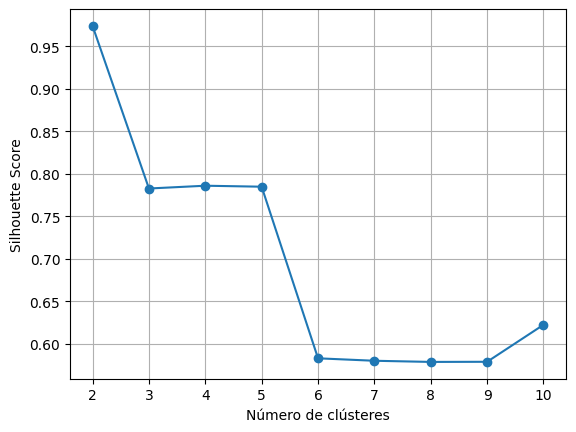

****************************************1************************************


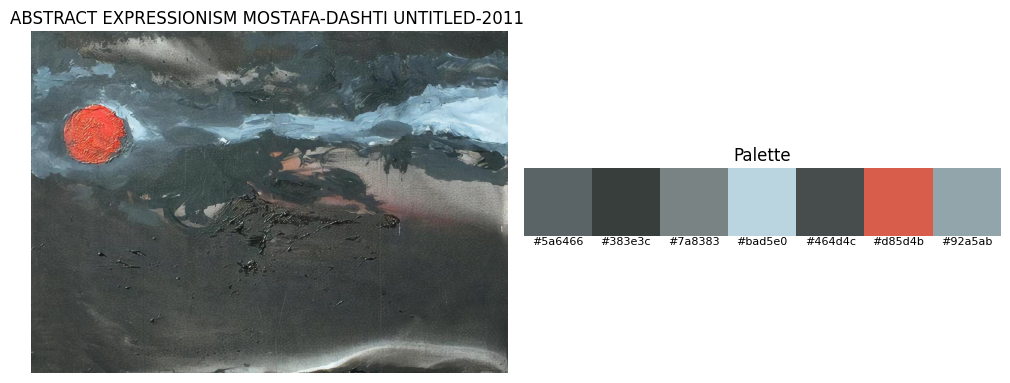

>> (7100, 2)


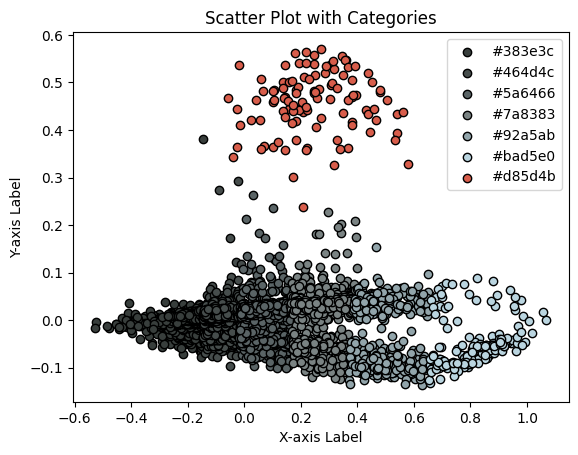

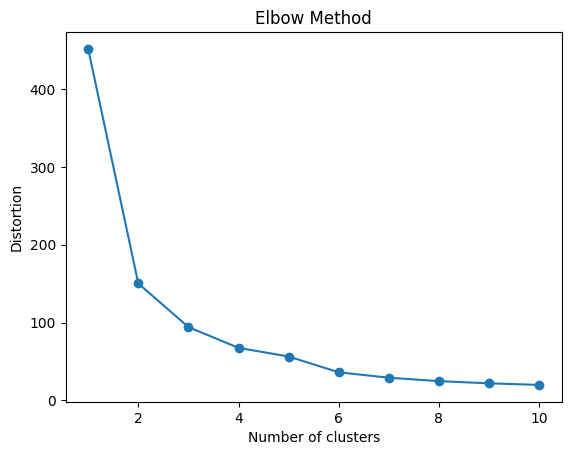

,K,Coeficiente
0,2,0.687498
1,3,0.594055
2,4,0.532671
3,5,0.550863
4,6,0.461314
5,7,0.443264
6,8,0.431786
7,9,0.416719
8,10,0.396608


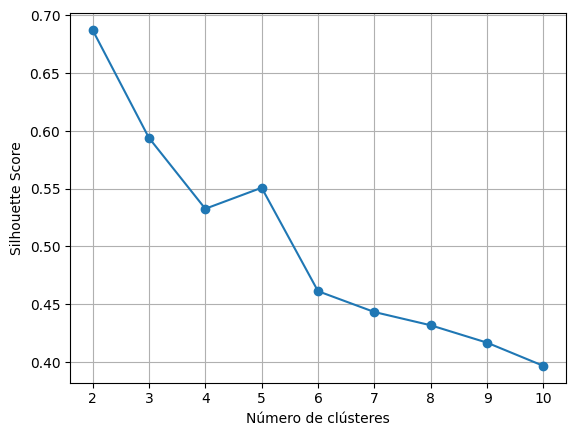

In [26]:
root_path = '/home/satoru/repos/u_andes/maia/mlns/micro_projects/one/sample'
root_path = '../../project_images/sample'
images_original = load_images(root_path)
images_process = pre_process_image(images_original, flatten=True, normalize=True, target_size=100)

num_clusters = 7
num_images = 2
processed_images = 0

for i, image in enumerate(images_process):
    print(f"****************************************{i}************************************")
    centroids,labels = kmeans_image(images_process[i],num_clusters)
    draw_image_palette(images_original[i], centroids)
    # plot_colors(centroids)
    x_train_reduced = dimensionality_reduction(images_process[i],centroids[labels])

    elbow_method(x_train_reduced)
    silhouette_plot(x_train_reduced)
    processed_images += 1
    if processed_images >= num_images:
        break

# Analizis con un grupo fijo de 100 imagenes

In [27]:
import pandas as pd

In [28]:
data = pd.read_csv('../siloute_100_100.csv')

In [29]:
data.describe()

,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.613901,0.542227,0.508238,0.478054,0.454096,0.438785,0.422136,0.412594,0.402151
std,0.110287,0.101184,0.094951,0.088007,0.084038,0.078515,0.073808,0.072973,0.071786
min,0.413652,0.323174,0.358966,0.328188,0.297365,0.292673,0.288811,0.287857,0.286479
25%,0.536288,0.479066,0.447793,0.420521,0.401077,0.384523,0.369392,0.359340,0.355356
50%,0.603706,0.520766,0.495410,0.465566,0.429557,0.430741,0.410825,0.396351,0.383408
75%,0.684022,0.590583,0.552592,0.517165,0.485914,0.466015,0.457353,0.448227,0.431120
max,0.973359,0.840561,0.804941,0.828541,0.813768,0.789711,0.680050,0.677156,0.671437


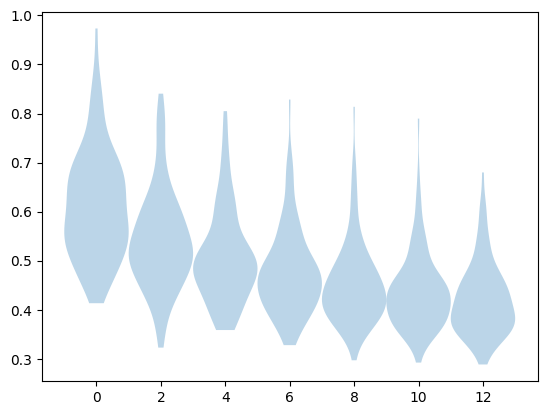

In [30]:
fig, ax = plt.subplots()
vp = ax.violinplot(data[['C_2','C_3','C_4','C_5','C_6','C_7','C_8']], [0,2, 4, 6,8,10,12], widths=2,
                   showmeans=False, showmedians=False, showextrema=False)

In [31]:
data[['C_2','C_3','C_4','C_5','C_6','C_7','C_8','C_9','C_10']].idxmax(axis=1).value_counts()


C_2    84
C_3     6
C_4     5
C_5     3
C_7     1
C_6     1
Name: count, dtype: int64

In [32]:
data[['C_5','C_6','C_7','C_8','C_9','C_10']].idxmax(axis=1).value_counts()


C_5    78
C_6    14
C_7     6
C_8     2
Name: count, dtype: int64

Realizando un análisis del rendimiento con la métrica de score silhouette se evidencia que tomando desde un k de 2 tiene el mejor rendimiento por lo general en grafica y al contar el máximo de cada fila también ek k de 2 es el cual mayor frecuencia se presenta.


Pero no tiene mucho sentido solo tener 2 colores. Por lo que se pudiese decir que a menor K tendrá mejor rendimiento de partición. Entonces si como restricción se tuviera un rango de número de colores deseados para mantener la mayor partición de los datos se debería de escoger el número menor en casos generales.
